In [2]:
from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#datasets_loc = "/content/drive/MyDrive/CNN project/datasets"

# Project 1 - Food Vision 
focus
preprocessing function 
batching and preparing datasets for modeling 
mixed precision training we need access to a Tesla T4 

beat DeepFood paper.
and using TensorBoad 
mixed precision

In [4]:
!nvidia-smi

Sun May  2 07:02:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f1dc6be9-4f71-af07-1426-0e19f95e0063)


In [6]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import itertools
import os
import datetime
import zipfile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [7]:
# note if is good to make a helper function and download it 

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Read in an image from filename, turns it into a tensor
  Reshape the (224,224,3)
  """
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)# decode image into a tensor
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img / 255.
  else:
    return img


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10,10),
                          text_size=15, norm=False, savefig=False):
  """

   Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
import tensorflow_datasets as tfds

In [9]:
(ds_train, ds_test), ds_info = tfds.load('food101',
                                         split=['train', 'validation'], 
                                         with_info=True,
                                         shuffle_files=True, 
                                         as_supervised=True)

In [10]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [11]:
# Hyperparmeter
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SHAPE = 224
class_name = ds_info.features['label'].names

In [ ]:
class_name

In [13]:
train_one_sample = ds_train.take(1)
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_name[label.numpy()]}
   """)


  Image shape: (288, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 33
  Class name (str form): edamame
   


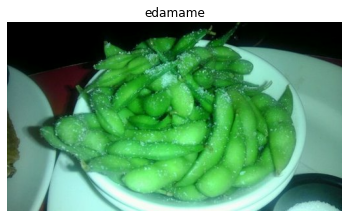

In [14]:
# plot the image
plt.imshow(image)
plt.title(class_name[label.numpy()])
plt.axis(False);

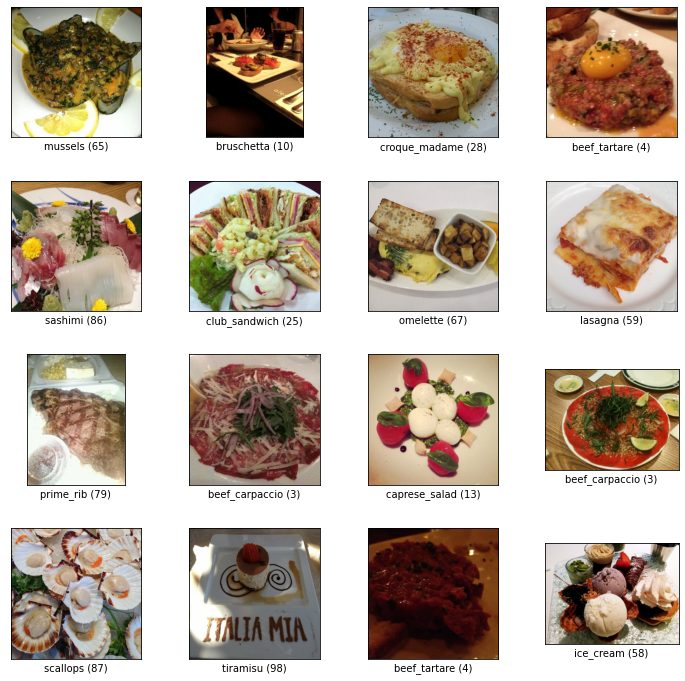

In [15]:
#show more images
fig = tfds.show_examples(ds_train, ds_info, rows=4,cols=4)

In [16]:
 def preprocess_img(image, label, img_shape=IMG_SHAPE):
   image = tf.image.resize(image, [img_shape, img_shape])
   image = tf.cast(image, tf.float32) / 255.0
   return image, label


In [17]:
ds_train = ds_train.map(preprocess_img, num_parallel_calls=AUTOTUNE).cache()
ds_train = ds_train.shuffle(buffer_size=1000).batch(BATCH_SIZE)
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)

ds_test = ds_test.map(preprocess_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)


In [18]:
ds_train, ds_test

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [19]:
# create some callback 
modelCheckpoint = '/content/checkpoints/cp.ckpt'
myModelCallbacks = tf.keras.callbacks.ModelCheckpoint(filepath=modelCheckpoint,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      verbose=0)
earlyStoping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

## Setup mixed precision training

this will speed up the training but you will need better GPU (like Tesla T4)
For deeper understanding of mixed precision training check out:
https://www.tensorflow.org/guide/mixed_precision?hl=en

# Important
In the output layer you need to precisse the data type dtype to float32

`
x = Dense(10)(x)
outputs= Activation('softmax', dtype='float32')(x)
`



In [20]:
#from tensorflow.keras import mixed_precision

In [21]:
#mixed_precision.set_global_policy('mixed_float16')

In [22]:
!nvidia-smi

Sun May  2 07:02:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |    349MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Building Model 

using Transfer learning for the extraction


In [23]:
from tensorflow.keras.layers import Dense, Input, Activation,\
 GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model



In [24]:
input_shape = (IMG_SHAPE, IMG_SHAPE, 3)
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(len(class_name))(x)
outputs = Activation('softmax', dtype=tf.float32)(x)
model = Model(inputs = inputs, outputs= outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
activation (Activation)      (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


when you label are interge use sparse_categorical_crossentropy
but if the labels are one hot encoded use categorical_crossentropy

In [25]:
model.compile(
   loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
   optimizer='adam',
   metrics=['accuracy']
)

In [26]:
for layer in model.layers:
  print(f'dtype of the layer: {layer.dtype}')

dtype of the layer: float32
dtype of the layer: float32
dtype of the layer: float32
dtype of the layer: float32
dtype of the layer: float32


In [ ]:
history_feature_extrac = model.fit(
    ds_train,
    epochs=50,
    steps_per_epoch=200,
    validation_data = ds_test,
    validation_steps= len(ds_test)/BATCH_SIZE,
    callbacks=[
               create_tensorboard_callback(dir_name='training logs',
                                           experiment_name='efficentnetb0_101'),
               myModelCallbacks,
               earlyStoping
    ])

Saving TensorBoard log files to: training logs/efficentnetb0_101/20210502-070301
Epoch 1/50
200/200 [==============================] - 34s 70ms/step - loss: 4.6491 - accuracy: 0.0131 - val_loss: 4.6307 - val_accuracy: 0.0113
INFO:tensorflow:Assets written to: /content/checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/checkpoints/cp.ckpt/assets


Epoch 2/50
200/200 [==============================] - 9s 47ms/step - loss: 4.6452 - accuracy: 0.0102 - val_loss: 4.6492 - val_accuracy: 0.0088
Epoch 3/50
200/200 [==============================] - 9s 47ms/step - loss: 4.6466 - accuracy: 0.0072 - val_loss: 4.6396 - val_accuracy: 0.0100
Epoch 4/50
200/200 [==============================] - 10s 49ms/step - loss: 4.6434 - accuracy: 0.0079 - val_loss: 4.6330 - val_accuracy: 0.0100
Epoch 5/50
200/200 [==============================] - 10s 51ms/step - loss: 4.6377 - accuracy: 0.0110 - val_loss: 4.6303 - val_accuracy: 0.0162
INFO:tensorflow:Assets written to: /content/checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/checkpoints/cp.ckpt/assets


Epoch 6/50
176/200 [=========================>....] - ETA: 1s - loss: 4.6434 - accuracy: 0.0083